In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import pickle

In [ ]:
chars = ""
with open('/content/drive/MyDrive/Colab Notebooks/wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text))
print(chars)
print(len(text))
print(text[:2000])
vocab_size = len(chars)

['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']
232311
﻿  DOROTHY AND THE WIZARD IN OZ

  BY

  L. FRANK BAUM

  AUTHOR OF THE WIZARD OF OZ, THE LAND OF OZ, OZMA OF OZ, ETC.

  ILLUSTRATED BY JOHN R. NEILL

  BOOKS OF WONDER WILLIAM MORROW & CO., INC. NEW YORK


  [Illustration]


  COPYRIGHT 1908 BY L. FRANK BAUM

  ALL RIGHTS RESERVED


         *       *       *       *       *


  [Illustration]


  DEDICATED TO HARRIET A. B. NEAL.


         *       *       *       *       *


To My Readers


It's no use; no use at all. The children won't let me stop telling tales
of the Land of Oz. I know lots of other stories, and I hope 

In [ ]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])
encoded_hello = encode('hello')
decoded_hello = decode(encoded_hello)
print(encoded_hello)
print(decoded_hello)
data = torch.tensor(encode(text), dtype = torch.long)
print(data[:100])

[61, 58, 65, 65, 68]
hello
tensor([80,  1,  1, 28, 39, 42, 39, 44, 32, 49,  1, 25, 38, 28,  1, 44, 32, 29,
         1, 47, 33, 50, 25, 42, 28,  1, 33, 38,  1, 39, 50,  0,  0,  1,  1, 26,
        49,  0,  0,  1,  1, 36, 11,  1, 30, 42, 25, 38, 35,  1, 26, 25, 45, 37,
         0,  0,  1,  1, 25, 45, 44, 32, 39, 42,  1, 39, 30,  1, 44, 32, 29,  1,
        47, 33, 50, 25, 42, 28,  1, 39, 30,  1, 39, 50,  9,  1, 44, 32, 29,  1,
        36, 25, 38, 28,  1, 39, 30,  1, 39, 50])


In [ ]:
block_size = 32
batch_size = 16
max_iters = 2000
eval_interval = 500
learning_rate = 3e-2
eval_iters = 300
n_embd = 384
n_head = 2
n_layer = 2
dropout = 0.3

In [ ]:
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

In [ ]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [ ]:
x, y = get_batch('train')
print('Inputs:')
print(x)
print('targets:')
print(y)

Inputs:
tensor([[72, 72, 58, 57,  1, 72, 58, 75, 58, 71, 54, 65,  1, 66, 68, 71, 58,  0,
         69, 71, 58, 73, 73, 78,  1, 56, 68, 73, 73, 54, 60, 58],
        [71, 68, 73, 61, 78,  9,  1, 76, 61, 68,  1, 67, 68, 73, 62, 56, 58, 57,
          1, 73, 61, 54, 73,  1, 73, 61, 58,  1, 55, 58, 54, 74],
        [ 1, 72, 73, 54, 62, 71, 76, 54, 78,  1, 73, 61, 54, 73,  0, 76, 62, 65,
         65,  1, 55, 71, 62, 67, 60,  1, 74, 72,  1, 68, 67,  1],
        [ 1, 67, 68, 76,  1, 66, 78,  1, 65, 68, 75, 62, 67, 60,  1, 73, 78, 71,
         54, 67, 73, 72,  1, 76, 68, 67,  5, 73,  1, 54, 65, 65],
        [61, 58, 71, 72,  1, 73, 61, 58,  1, 65, 54, 72, 73,  1, 31, 54, 71, 60,
         68, 78, 65, 58,  1, 72, 62, 65, 58, 67, 73, 65, 78,  1],
        [ 1, 26, 74, 73,  1, 33,  1, 61, 54, 75, 58,  1, 55, 58, 58, 67,  1, 58,
         77, 54, 66, 62, 67, 62, 67, 60,  1, 73, 61, 62, 72,  1],
        [26, 74, 73,  1, 58, 75, 58, 67,  0, 73, 61, 54, 73,  1, 57, 62, 57,  1,
         67, 68, 73,  1, 72, 

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print('when input is', context, 'target is', target)

when input is tensor([80]) target is tensor(1)
when input is tensor([80,  1]) target is tensor(1)
when input is tensor([80,  1,  1]) target is tensor(28)
when input is tensor([80,  1,  1, 28]) target is tensor(39)
when input is tensor([80,  1,  1, 28, 39]) target is tensor(42)
when input is tensor([80,  1,  1, 28, 39, 42]) target is tensor(39)
when input is tensor([80,  1,  1, 28, 39, 42, 39]) target is tensor(44)
when input is tensor([80,  1,  1, 28, 39, 42, 39, 44]) target is tensor(32)
when input is tensor([80,  1,  1, 28, 39, 42, 39, 44, 32]) target is tensor(49)
when input is tensor([80,  1,  1, 28, 39, 42, 39, 44, 32, 49]) target is tensor(1)
when input is tensor([80,  1,  1, 28, 39, 42, 39, 44, 32, 49,  1]) target is tensor(25)
when input is tensor([80,  1,  1, 28, 39, 42, 39, 44, 32, 49,  1, 25]) target is tensor(38)
when input is tensor([80,  1,  1, 28, 39, 42, 39, 44, 32, 49,  1, 25, 38]) target is tensor(28)
when input is tensor([80,  1,  1, 28, 39, 42, 39, 44, 32, 49,  1, 2

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

# [1, 0, 0]
# [1, 0.6, 0]
# [1, 0.6, 0.4]
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape


        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

model = GPTLanguageModel(vocab_size)
# print('loading model parameters...')
# with open('model-01.pkl', 'rb') as f:
# model = pickle.load(f)
# print('loaded successfully!')

step: 0, train loss: 4.501, val loss: 4.496
step: 300, train loss: 3.191, val loss: 3.214
step: 600, train loss: 3.153, val loss: 3.164
step: 900, train loss: 3.162, val loss: 3.162
step: 1200, train loss: 3.143, val loss: 3.154
step: 1500, train loss: 3.144, val loss: 3.150
step: 1800, train loss: 3.146, val loss: 3.160


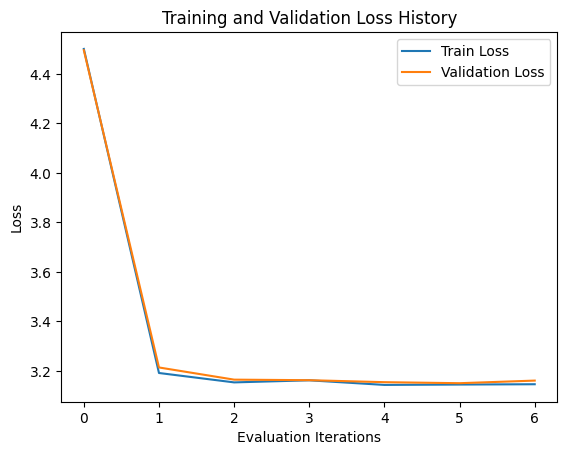

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loss_history = []
val_loss_history = []
for iter in range(max_iters):
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")
        train_loss_history.append(losses['train'])
        val_loss_history.append(losses['val'])
    xb, yb = get_batch('train')
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Plot the loss history after training
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Evaluation Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.show()

In [ ]:
context = torch.zeros((1,1), dtype=torch.long)
generated_chars = decode(model.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)


ieado a vot,er
s  d xeeWi  Tcao
iwmrpdE its.l'i tTd;rsrrft;k "ts nsh r, eaeet a" soste"t ut aO  oNDas
fcctsgahEer e oeoe ncardaoa e CnZpI  oiag 
dsW.ImHv"t cnezoattuod.aa -oirn   .ku sep edar o b h .llhgo ass tp .arteotneawhu.i psiaa r
tt
oagiuhh lwfoNt lZp  cho h wodpWsf"itimnPO tliimot  s rri 
htg eocoet"-rfrieetorteno taoo eitr gtitssryvoyGdu  oiedxneotu  epDengho jgc
wttadsleeyIhlwf n"
smn, arrtfhpco  
D"bnlnwG
ie itk seelgetlerttie
pfn d phcnen    ggrawr  wspl ia"shbp Lnrs sd o "l e   eicnd


In [ ]:
flag = 1
while flag != 0:
    prompt = input("Prompt:\n")
    context = torch.tensor(encode(prompt), dtype=torch.long)
    generated_chars = decode(model.generate(context.unsqueeze(0), max_new_tokens=150)[0].tolist())
    print(f'Completion:\n{generated_chars}')

Prompt:
Hello
Completion:
Hellooets r uA,
 na i " ck
 vbohhnt  cg
n i etJnatdiw bpeahrohWe iap  rwwis l od-ueIntO"tgj z* ietrp ce eh  hr wetW w s agts"fg  h luaeyvgt   "uth yew enah
Prompt:
baby
Completion:
babytaiem,ie e.l?ea,creanm
grh
 c.eeheep netr a  t JOt
vv  traOeaogatmr tceheeit ov  atigucun eeaae   v ecvlgletlskattl is  ltfnot g 
eetlgtdt 
 kDsyhsfsb
Prompt:
kantap padega
Completion:
kantap padegaidPct"uwceunie neoh.'aCa
Heldvcbi .w i muhwtehniurYi renw vs
dgpfde"redabtTie L"ee oh"tCtcnrhAut Hr H"oyalsiehn"t
aglIdoseadttxt eH oarenie i,dhend"sw


KeyboardInterrupt: Interrupted by user

In [ ]:
!pip install gradio
import gradio as gr
import torch

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape


        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

from gradio import Textbox

def predict(prompt):
    context = torch.tensor(encode(prompt), dtype=torch.long)
    generated_chars = decode(model.generate(context.unsqueeze(0), max_new_tokens=150)[0].tolist())
    return generated_chars

iface = gr.Interface(
    fn=predict,
    # Directly use Textbox
    inputs=Textbox(lines=2, placeholder="Enter your prompt here..."),
    outputs="text",
    title="Wizard of Oz LLM",
    description="This LLM is trained on the Wizard of Oz text.",
)

iface.launch()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Hyperparameters (adjust as necessary)
n_embd = 256        # Embedding dimension
block_size = 128    # Maximum number of tokens in the context
n_layer = 4         # Number of transformer blocks
n_head = 8          # Number of attention heads
dropout = 0.12      # Dropout probability
vocab_size = len(chars)  # Size of the vocabulary (adjust as per your tokenizer)

class Head(nn.Module):
    """One head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        wei = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # Mask
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x)  # (B, T, head_size)
        out = wei @ v  # (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # Concatenate heads
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """A simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        tok_emb = self.token_embedding_table(index)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=index.device))  # Device agnostic positional embedding
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)  # (B, T, C)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def top_k_sampling(self, logits, k=10):
        values, indices = torch.topk(logits, k=k)
        top_probs = F.softmax(values, dim=-1)
        return torch.multinomial(top_probs, num_samples=1)

    def generate(self, index, max_new_tokens, temperature=1.0, top_k=10):
        for _ in range(max_new_tokens):
            index_cond = index[:, -block_size:]  # Crop to block size
            logits, _ = self.forward(index_cond)
            logits = logits[:, -1, :]  # Focus on last time step
            logits = logits / temperature  # Apply temperature
            index_next = self.top_k_sampling(logits, k=top_k)  # Top-k sampling
            index = torch.cat((index, index_next), dim=1)  # Append to sequence
        return index

# Model instantiation
model = GPTLanguageModel(vocab_size)

# Example usage
index = torch.tensor([[1, 2, 3]])  # Dummy tokenized input
max_new_tokens = 50  # Number of tokens to generate
generated_text = model.generate(index, max_new_tokens=max_new_tokens, temperature=1.0, top_k=10)

print(generated_text)


In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loss_history = []
val_loss_history = []
for iter in range(max_iters):
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")
        train_loss_history.append(losses['train'])
        val_loss_history.append(losses['val'])
    xb, yb = get_batch('train')
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Plot the loss history after training
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Evaluation Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.show()

In [ ]:
import gradio as gr
import torch

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        tok_emb = self.token_embedding_table(index)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=index.device))  # Device agnostic positional embedding
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)  # (B, T, C)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def top_k_sampling(self, logits, k=10):
        values, indices = torch.topk(logits, k=k)
        top_probs = F.softmax(values, dim=-1)
        return torch.multinomial(top_probs, num_samples=1)

    def generate(self, index, max_new_tokens, temperature=1.0, top_k=10):
        for _ in range(max_new_tokens):
            index_cond = index[:, -block_size:]  # Crop to block size
            logits, _ = self.forward(index_cond)
            logits = logits[:, -1, :]  # Focus on last time step
            logits = logits / temperature  # Apply temperature
            index_next = self.top_k_sampling(logits, k=top_k)  # Top-k sampling
            index = torch.cat((index, index_next), dim=1)  # Append to sequence
        return index

from gradio import Textbox

def predict(prompt):
    context = torch.tensor(encode(prompt), dtype=torch.long)
    generated_chars = decode(model.generate(context.unsqueeze(0), max_new_tokens=150)[0].tolist())
    return generated_chars

iface = gr.Interface(
    fn=predict,
    # Directly use Textbox
    inputs=Textbox(lines=2, placeholder="Enter your prompt here..."),
    outputs="text",
    title="NeuroForge",
    description="This is an Encoder-decoder LLM",
)

iface.launch()